## Ames Data


This data set contains information from the Ames Assessor's Office, which is used to compute assessed values for individual residential properties sold in Ames, IA from 2006 to 2010. A full description of the data is available [here](https://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

### Importing data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [6]:
ames = pd.read_csv('../datasets/train.csv')
ames.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [7]:
ames.shape

(2051, 81)

## Data Cleaning

This notebook evaluates the observations in the sample and determines whether any data cleaning is necessary before proceeding to the modeling step. In this process, various exploratory data analysis techniques will also be employed.

#### Duplicates

In [8]:
# There are no complete duplicates. This does not mean duplicates do not exist. I'm still not fully sure of the 
# data structure. 
print(ames.duplicated().sum())
ames.duplicated(subset=['Id']).sum()

0


0

> There are no duplicate rows in the sample.

#### Renaming column names:

In [9]:
ames.columns = ames.columns.str.lower().str.replace(' ', '_')
ames.rename(columns={'id':'Id', 'saleprice':'SalePrice', 'year_remod/add':'year_remod', '2nd_flr_sf':'second_flr_sf', 
                         '1st_flr_sf':'first_flr_sf'}, inplace=True)

PID is a unique identifier. Goven that we already have id. There is no need to keep PID.

In [10]:
for col in ['alley', 'fence', 'fireplace_qu', 'garage_finish', 'garage_type', 'bsmt_exposure', 'bsmt_cond', 'bsmt_qual', 
            'mas_vnr_type', 'bsmtfin_type_1', 'bsmtfin_type_2', 'electrical']:
    ames[col].fillna('missing', inplace=True)
        

In [11]:
ames['fireplace_qu'].value_counts(dropna=False)

missing    1000
Gd          523
TA          407
Fa           59
Po           31
Ex           31
Name: fireplace_qu, dtype: int64

In [12]:
ames['pid'].nunique()

2051

Based on the data description, we know that the `PID` column represents the Parcel Identification Number, and it is unique for all rows in the sample. Since we already have the `Id` column, which presumably serves as a unique identifier for each row, there is no need to retain the `PID` column.

### Missing Values

In [13]:
ames.isna().sum().sort_values(ascending=False).head(30)

pool_qc            2042
misc_feature       1986
lot_frontage        330
garage_yr_blt       114
garage_qual         114
garage_cond         114
mas_vnr_area         22
bsmt_full_bath        2
bsmt_half_bath        2
bsmtfin_sf_2          1
bsmt_unf_sf           1
bsmtfin_sf_1          1
total_bsmt_sf         1
garage_area           1
garage_cars           1
functional            0
full_bath             0
half_bath             0
bedroom_abvgr         0
kitchen_abvgr         0
gr_liv_area           0
kitchen_qual          0
low_qual_fin_sf       0
totrms_abvgrd         0
Id                    0
garage_finish         0
fireplaces            0
screen_porch          0
sale_type             0
yr_sold               0
dtype: int64

> As can be observed, there are several features in the dataset that contain missing values. In the following subsection, I will delve into each of these features individually to analyze and address the missing data.

### Handling missing values

#### Handling Missing values among categorical variables

In [14]:
ames['pool_qc'].value_counts(dropna=False)

NaN    2042
Gd        4
Fa        2
TA        2
Ex        1
Name: pool_qc, dtype: int64

The presence of "NA" values in the `pool_qc` column indicates that the house does not have a pool. Since only a few houses have pools with any quality information available, one option could be to remove the `pool_qc` variable altogether. Alternatively, you could create a dummy variable that indicates whether the house has a pool or not. This dummy variable would have a value of 1 if the house has a pool and 0 if it does not. This approach can simplify the analysis and modeling process while capturing the presence or absence of a pool as a binary feature

In [15]:
ames['misc_feature'].value_counts(normalize=True, dropna=False)

NaN     0.968308
Shed    0.027304
Gar2    0.001950
Othr    0.001463
TenC    0.000488
Elev    0.000488
Name: misc_feature, dtype: float64

In [16]:
ames['fence'].value_counts(normalize=True, dropna=False)

missing    0.804973
MnPrv      0.110678
GdPrv      0.040468
GdWo       0.039005
MnWw       0.004876
Name: fence, dtype: float64

Same as `pool_qc`, I'm going to create a new column that represents whether the house has additional features. Since this is the second variable with the same problem, I'm going to write a function that automates this task. Using this funtion  I also, create a column that that indicate whether a house has fence (`have_fence`).

In [17]:
def is_not_na(col, name):
    ames[name] = np.where(ames[col].isna(), 1, 0)

In [18]:
is_not_na(col='pool_qc', name='have_pool')
is_not_na(col='misc_feature', name='have_misc_features')
is_not_na(col='fence', name='have_fence')

In [19]:
ames['have_pool'].value_counts(normalize=True, dropna=False)

1    0.995612
0    0.004388
Name: have_pool, dtype: float64

In [20]:
ames['have_misc_features'].value_counts(normalize=True, dropna=False)

1    0.968308
0    0.031692
Name: have_misc_features, dtype: float64

In [21]:
ames['have_fence'].value_counts(normalize=True, dropna=False)

0    1.0
Name: have_fence, dtype: float64

In [22]:
ames['alley'].value_counts(normalize=True, dropna=False)
#replacing NaN with no Alley access

missing    0.931741
Grvl       0.041443
Pave       0.026816
Name: alley, dtype: float64

In [23]:
ames['alley'] = ames['alley'].map({'Grvl':'gravel', 'Pave':'paved', np.nan:'no_alley_access'})

In [24]:
ames['fence'].value_counts(normalize=True, dropna=False)

       # GdPrv	Good Privacy
       # MnPrv	Minimum Privacy
       # GdWo	Good Wood
       # MnWw	Minimum Wood/Wire
       # NA	No Fence

missing    0.804973
MnPrv      0.110678
GdPrv      0.040468
GdWo       0.039005
MnWw       0.004876
Name: fence, dtype: float64

In [25]:
ames['fence'] = ames['fence'].map({'GdPrv':'good_privacy', 'MnPrv':'min_privacy', 'GdWo':'good_wood', 'MnWw': 'min_wood/wire', np.nan:'no_fence'})
ames['fence'] = pd.Categorical(ames['fence'], categories=['good_privacy', 'min_privacy', 'good_wood', 'min_wood/wire', 'no_fence'], ordered=True) 

In [26]:
ames['fireplace_qu'] = ames['fireplace_qu'].map({'Ex': 'excellent', 'Gd':'good', 'TA':'average', 'Fa': 'fair', 'Po':'poor', np.nan:'no_fireplace'})
ames['fireplace_qu'] = pd.Categorical(ames['fireplace_qu'], categories=['excellent', 'good', 'average', 'fair', 'poor', 'no_fireplace'], ordered=True) 

In [27]:
ames['fireplace_qu'].value_counts(normalize=True, dropna=False)

NaN             0.487567
good            0.254998
average         0.198440
fair            0.028766
excellent       0.015115
poor            0.015115
no_fireplace    0.000000
Name: fireplace_qu, dtype: float64

In [28]:
ames['garage_finish'].value_counts(normalize=True, dropna=False)

Unf        0.413944
RFn        0.282301
Fin        0.248172
missing    0.055583
Name: garage_finish, dtype: float64

In [29]:
ames['garage_finish'] = ames['garage_finish'].map({'Fin': 'finished', 'RFn':'rough_finished', 'Unf':'unfinished', np.nan:'no_garage'})
ames['garage_finish'] = pd.Categorical(ames['garage_finish'], categories=['finished', 'rough_finished', 'unfinished', 'no_garage'], ordered=True) 

Both `garage_qual` and `garage_cond` exhibit low variance and relatively high missing values. As a result, they will be excluded from the final sample.

In [30]:
ames['garage_qual'].value_counts(normalize=True, dropna=False)

TA     0.893223
NaN    0.055583
Fa     0.039980
Gd     0.008776
Ex     0.001463
Po     0.000975
Name: garage_qual, dtype: float64

In [31]:
ames['garage_cond'].value_counts(normalize=True, dropna=False)

TA     0.910775
NaN    0.055583
Fa     0.022916
Gd     0.005851
Po     0.003901
Ex     0.000975
Name: garage_cond, dtype: float64

In [32]:
ames['garage_type'].value_counts(normalize=True, dropna=False)

Attchd     0.591419
Detchd     0.261336
BuiltIn    0.064359
missing    0.055095
Basment    0.013164
2Types     0.009264
CarPort    0.005363
Name: garage_type, dtype: float64

In [33]:
ames['garage_type'] = ames['garage_type'].map({'Attchd': 'attached_to_home', 'Detchd':'detached_from_home', '2Types':'2types', 'CarPort':'carport', 
                                               'BuiltIn':'built_in' , 'Basment':'basement_garage', np.nan:'no_garage'})

In [34]:
ames['bsmt_exposure'].value_counts(normalize=True, dropna=False)

No         0.652852
Av         0.140419
Gd         0.098976
Mn         0.079473
missing    0.028279
Name: bsmt_exposure, dtype: float64

In [35]:
ames['bsmt_exposure'] = ames['bsmt_exposure'].map({'No': 'no_exposure', 'Mn':'min_exposure', 'Av':'avg_exposure', 'Gd':'good_exposure', np.nan:'no_basement'})

ames['bsmt_exposure'] = pd.Categorical(ames['bsmt_exposure'], categories=['good_exposure', 'avg_exposure', 'min_exposure', 
                                                                          'no_exposure', 'no_basement'], ordered=True)

In [36]:
ames['bsmtfin_type_1'].value_counts(normalize=True, dropna=False)

GLQ        0.299854
Unf        0.294003
ALQ        0.142857
BLQ        0.097513
Rec        0.089225
LwQ        0.049732
missing    0.026816
Name: bsmtfin_type_1, dtype: float64

In [37]:
ames['bsmtfin_type_1'] = ames['bsmtfin_type_1'].fillna('no_basement').str.lower()
ames['bsmtfin_type_1'] = pd.Categorical(ames['bsmtfin_type_1'], categories=['glq', 'alq', 'blq', 'rec', 'lwq', 'unf', 'no_basement'], ordered=True)

# GLQ	Good Living Quarters
# ALQ	Average Living Quarters
# BLQ	Below Average Living Quarters	
# Rec	Average Rec Room
# LwQ	Low Quality
# Unf	Unfinshed
# NA	No Basement

In [38]:
ames['bsmtfin_type_2'].value_counts(normalize=True, dropna=False)

Unf        0.852755
Rec        0.039005
LwQ        0.029254
missing    0.027304
BLQ        0.023403
ALQ        0.017065
GLQ        0.011214
Name: bsmtfin_type_2, dtype: float64

In [39]:
ames['bsmtfin_type_2'] = ames['bsmtfin_type_2'].fillna('no_basement').str.lower()
ames['bsmtfin_type_2'] = pd.Categorical(ames['bsmtfin_type_2'], categories=['glq', 'alq', 'blq', 'rec', 'lwq', 'unf', 'no_basement'], ordered=True)

Due to the limited variation observed in `bsmtfin_type_2`, it will also be removed from the sample. This variable consists of seven categories, with one category accounting for 85 percent of the sample and the remaining six categories collectively accounting for 15 percent. While the variable itself will be removed, a binary feature will be created based on it to capture the presence or absence of a specific type of basement finish.

In [40]:
pd.crosstab(ames['bsmtfin_type_1'], ames['bsmtfin_type_2'], margins=True)

bsmtfin_type_2,glq,alq,blq,rec,lwq,unf,All
bsmtfin_type_1,,,,,,,
glq,0,11,6,17,11,569,614
alq,3,0,23,25,16,226,293
blq,7,3,1,28,18,143,200
rec,4,10,10,0,15,144,183
lwq,9,11,8,10,0,64,102
unf,0,0,0,0,0,603,603
All,23,35,48,80,60,1749,1995


In [41]:
ames['bsmtfin_type_2_unf'] = np.where(ames['bsmtfin_type_2'] == 'unf', 'Yes', 'No')

In [42]:
ames['bsmt_cond'].value_counts(normalize=True, dropna=False)
       # Ex	Excellent
       # Gd	Good
       # TA	Typical - slight dampness allowed
       # Fa	Fair - dampness or some cracking or settling
       # Po	Poor - Severe cracking, settling, or wetness
       # NA	No Basement

TA         0.894198
Gd         0.043393
Fa         0.031692
missing    0.026816
Po         0.002438
Ex         0.001463
Name: bsmt_cond, dtype: float64

In [43]:
ames['bsmt_cond'] = ames['bsmt_cond'].map({'Ex': 'excellent', 'Gd':'good', 'TA':'average', 'Fa': 'fair', 'Po':'poor', np.nan:'no_basement'})
ames['bsmt_cond'] = pd.Categorical(ames['bsmt_cond'], categories=['excellent', 'good', 'average', 'fair', 'poor', 'no_basement'], ordered=True) 

In [44]:
ames['bsmt_qual'].value_counts(normalize=True, dropna=False)
       # Ex	Excellent (100+ inches)	
       # Gd	Good (90-99 inches)
       # TA	Typical (80-89 inches)
       # Fa	Fair (70-79 inches)
       # Po	Poor (<70 inches
       # NA	No Basement

TA         0.432472
Gd         0.421258
Ex         0.089712
Fa         0.029254
missing    0.026816
Po         0.000488
Name: bsmt_qual, dtype: float64

In [45]:
ames['bsmt_qual'] = ames['bsmt_qual'].map({'Ex': 'excellent', 'Gd':'good', 'TA':'average', 'Fa': 'fair', 'Po':'poor', np.nan:'no_basement'})
ames['bsmt_qual'] = pd.Categorical(ames['bsmt_qual'], categories=['excellent', 'good', 'average', 'fair', 'poor', 'no_basement'], ordered=True) 

In [46]:
ames['mas_vnr_type'].value_counts(normalize=True, dropna=False)

       # BrkCmn	Brick Common
       # BrkFace	Brick Face
       # CBlock	Cinder Block
       # None	None
       # Stone	Stone

None       0.593857
BrkFace    0.307167
Stone      0.081911
missing    0.010726
BrkCmn     0.006338
Name: mas_vnr_type, dtype: float64

In [47]:
ames['mas_vnr_type'].value_counts()

None       1218
BrkFace     630
Stone       168
missing      22
BrkCmn       13
Name: mas_vnr_type, dtype: int64

In [48]:
ames['mas_vnr_type'] = ames['mas_vnr_type'].map({'BrkCmn': 'brick_common', 'BrkFace':'brick_ace', 'Stone':'stone', 
                                                 'CBlock':'cinder_block', 'None': 'none', np.nan:'none'})

### Handling Missing values among numeric variables
For numerical features with a small number of missing values that can be sensibly replaced, two common approaches are to substitute the missing values with either 0 or the mean of the variable.

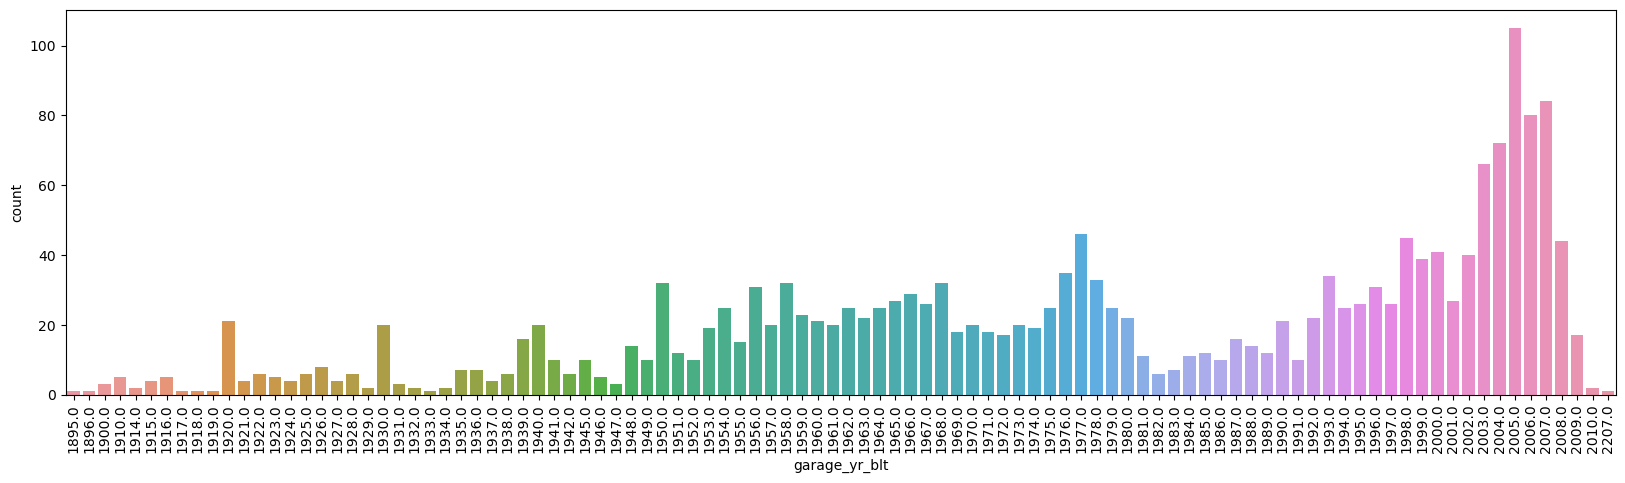

In [49]:
ames['garage_yr_blt'].value_counts(normalize=True, dropna=False)

plt.figure(figsize=(20, 5))
sns.countplot(data = ames, x = 'garage_yr_blt')
plt.xticks(rotation=90);

In [50]:
ames.loc[ames['garage_yr_blt'].notna(), ['year_built', 'garage_yr_blt']].corr()

,year_built,garage_yr_blt
year_built,1.000000,0.825316
garage_yr_blt,0.825316,1.000000


<Axes: xlabel='year_built', ylabel='garage_yr_blt'>

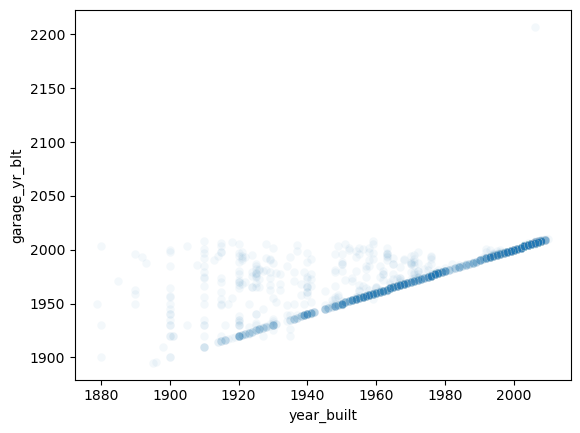

In [51]:
sns.scatterplot(data=ames, x='year_built', y='garage_yr_blt', alpha=0.05)

It is evident that `year_built` and `garage_yr_blt` are highly correlated variables. Additionally, there is a falsely recorded value of 2200 for `garage_yr_blt`. Considering these factors, it is reasonable to drop `garage_yr_blt` from the sample. This variable can be safely removed without significantly impacting the analysis.

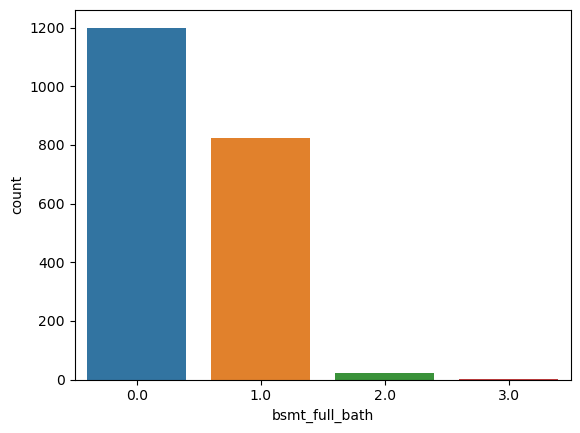

In [52]:
sns.countplot(data = ames, x = 'bsmt_full_bath');

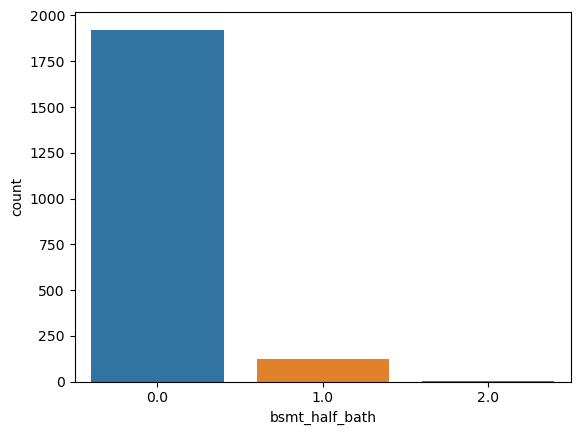

In [53]:
sns.countplot(data = ames, x = 'bsmt_half_bath');
#replace na with zero

In [54]:
ames['bsmt_full_bath'].isna().sum()

2

In [55]:
ames['bsmt_half_bath'].isna().sum()

2

In [56]:
ames['bsmt_full_bath'].fillna(0, inplace=True)
ames['bsmt_half_bath'].fillna(0, inplace=True)

We can create a new feature that represents the weighted sum of both full and half baths, utilizing the `bsmt_full_bath` and `bsmt_half_bath` variables. This can be achieved by assigning a weight of 1 to each full bath and a weight of 0.5 to each half bath, and then summing them together. By calculating the weighted sum of full and half baths, we can obtain a single feature that captures the overall count of baths, accounting for both full and half baths in the basement.

In [57]:
ames['bsmt_total_bath'] =ames['bsmt_full_bath'] + 0.5*ames['bsmt_half_bath'] 

In [58]:
ames['garage_area'].isna().sum()

1

In [59]:
ames['garage_area'].fillna(0, inplace=True)

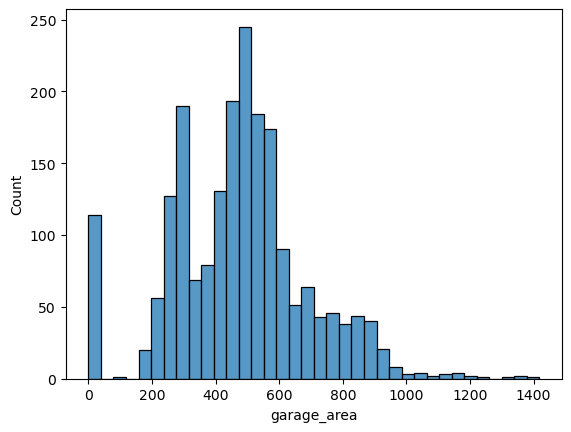

In [60]:
sns.histplot(data = ames, x = 'garage_area');

In [61]:
ames['total_bsmt_sf'].isna().sum()

1

In [62]:
ames['total_bsmt_sf'].fillna(0, inplace=True)

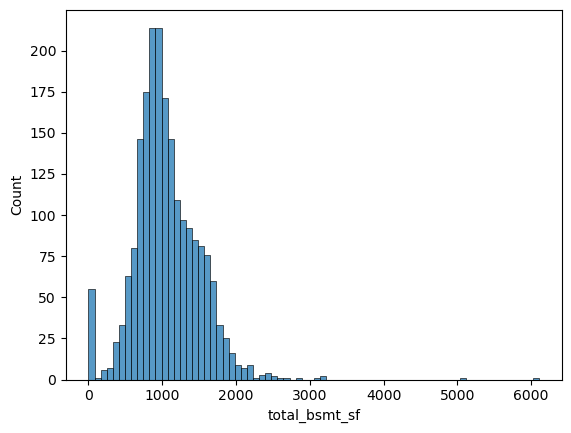

In [63]:
sns.histplot(data = ames, x = 'total_bsmt_sf');
#replace na with zero

In [64]:
ames['bsmtfin_sf_1'].isna().sum()

1

In [65]:
ames['bsmtfin_sf_1'].fillna(0, inplace=True)

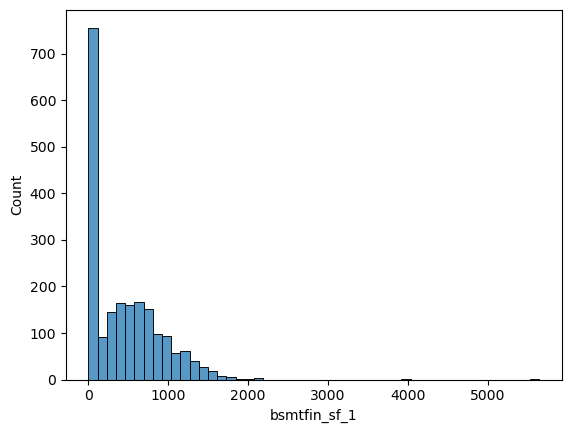

In [66]:
sns.histplot(data = ames, x = 'bsmtfin_sf_1');
#replace na with 0

In [67]:
ames['bsmtfin_sf_2'].isna().sum()

1

In [68]:
ames['bsmtfin_sf_2'].fillna(0, inplace=True)

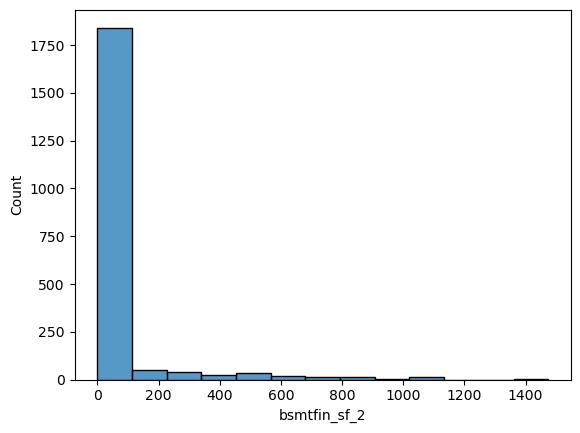

In [69]:
sns.histplot(data = ames, x = 'bsmtfin_sf_2');

In [70]:
ames['bsmt_unf_sf'].isna().sum()

1

In [71]:
ames['bsmt_unf_sf'].fillna(0, inplace=True)

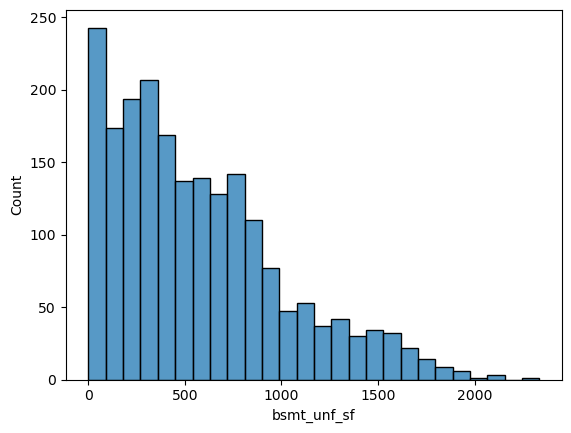

In [72]:
sns.histplot(data = ames, x = 'bsmt_unf_sf');

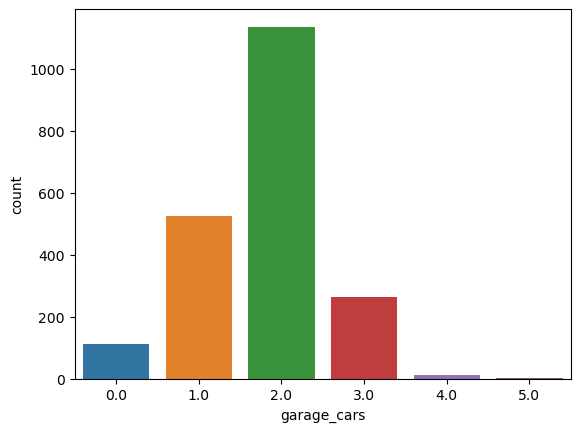

In [73]:
sns.countplot(data = ames, x = 'garage_cars');

The following features have only one or two missing values, which suggests it is safe to replace those missing values with 0. However, to ensure accuracy, I create an alternative version of the dataset where the missing values are replaced with the mean of the respective feature. This ideally will allow for a more robust analysis and comparison between the two versions.

In [74]:
col_with_missing = ['bsmt_full_bath', 'bsmt_half_bath', 'garage_cars', 'bsmt_unf_sf', 'bsmtfin_sf_2', 'bsmtfin_sf_1', 'total_bsmt_sf', 'garage_area']

for col in col_with_missing:
    ames[col].fillna(0, inplace=True)

Similar to the approach used for other variables discussed above, you can handle missing values in the `lot_frontage` variable by considering two options: replacing them with zero or replacing them with the mean value.

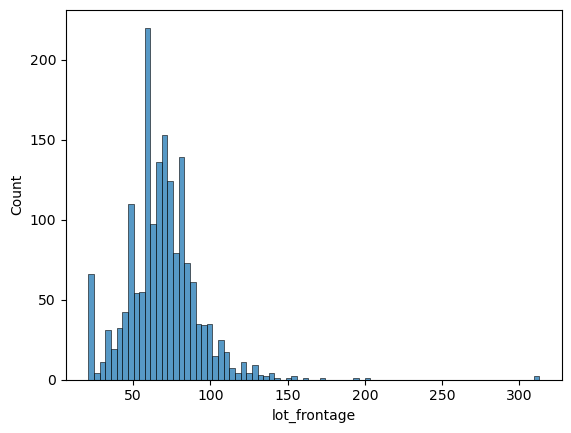

In [75]:
sns.histplot(data = ames, x = 'lot_frontage');

In [76]:
ames.loc[ames['lot_frontage'].notna(), ['lot_frontage', 'SalePrice']].corr()

,lot_frontage,SalePrice
lot_frontage,1.000000,0.341842
SalePrice,0.341842,1.000000


In [77]:
ames['lot_frontage'] = ames['lot_frontage'].fillna(ames['lot_frontage'].mean())

In [78]:
ames['mas_vnr_area'].isna().sum()

22

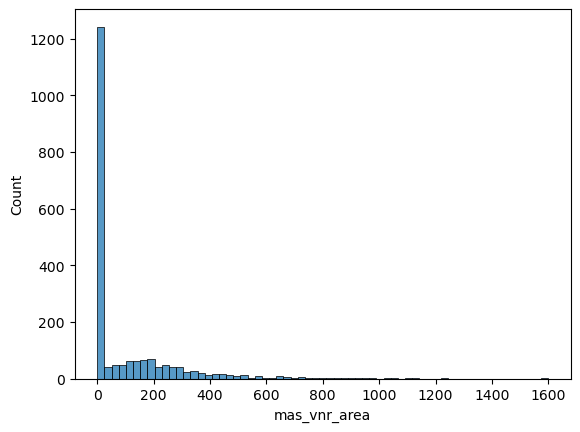

In [79]:
sns.histplot(data = ames, x = 'mas_vnr_area');

In [80]:
ames['mas_vnr_area']

0       289.0
1       132.0
2         0.0
3         0.0
4         0.0
        ...  
2046      0.0
2047      0.0
2048      0.0
2049      0.0
2050      0.0
Name: mas_vnr_area, Length: 2051, dtype: float64

Following the same approach as before, I replace the missing values in the `mas_vnr_area` variable with its mean and zero in two separete version of the sample.

In [81]:
ames['mas_vnr_area'] = np.where(ames['mas_vnr_area'].isna(), 0, ames['mas_vnr_area'])

In [82]:
ames['have_mas_vnr'] = np.where(ames['mas_vnr_area']==0, 0, 1)

In [83]:
ames['electrical'].replace(np.nan, 'Mix', inplace=True)

In [84]:
ames.isna().sum().sort_values(ascending=False).head(10)

pool_qc          2042
misc_feature     1986
alley            1911
fence            1651
fireplace_qu     1000
garage_qual       114
garage_finish     114
garage_yr_blt     114
garage_cond       114
garage_type       113
dtype: int64

In all categorical variables, if there are categories with low frequencies, I group those categories into a new category called **Other**. This approach can help simplify the analysis by reducing the number of distinct categories.


## Cleaning the Data types

In [85]:
ames['ms_zoning'].value_counts()
       # A	Agriculture
       # C	Commercial
       # FV	Floating Village Residential
       # I	Industrial
       # RH	Residential High Density
       # RL	Residential Low Density
       # RP	Residential Low Density Park 
       # RM	Residential Medium Density

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64

In [86]:
ames['ms_zoning'] = ames['ms_zoning'].map({'RL': 'residential_low_density', 'RM':'residential_medium_density', 'FV':'floating_village_residential', 
                                           'C (all)': 'commercial', 'RH':'residential_high_density', 'A (agr)':'agriculture', 'I (all)':'industrial'})
ames['ms_zoning'] = pd.Categorical(ames['ms_zoning'], categories=['residential_low_density', 'residential_medium_density', 
                                                                  'floating_village_residential', 'commercial', 'residential_high_density', 
                                                                  'agriculture', 'industrial'], ordered=False) 

In [87]:
ames[['ms_zoning', 'overall_qual']].dtypes

ms_zoning       category
overall_qual       int64
dtype: object

In [88]:
ames['ms_zoning'].value_counts()

residential_low_density         1598
residential_medium_density       316
floating_village_residential     101
commercial                        19
residential_high_density          14
agriculture                        2
industrial                         1
Name: ms_zoning, dtype: int64

> I'm removing the two house with more than 4000 sq in size.

## Feature enginearing and EDA

In [89]:
ames['age'] = ames['yr_sold'] - ames['year_built']

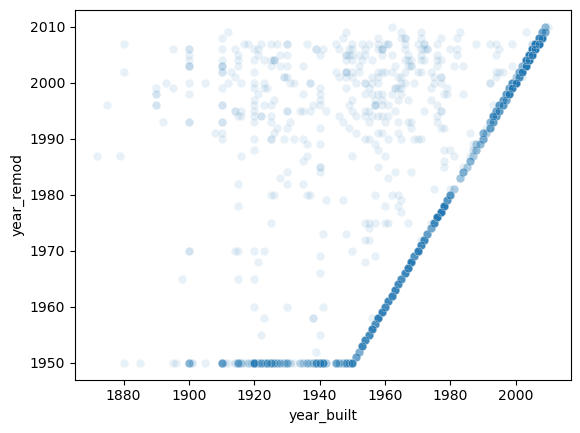

In [90]:
sns.scatterplot(y=ames['year_remod'], x=ames['year_built'], alpha=0.1);

In [91]:
ames['total_bath'] = ames['full_bath'] + 0.5 * ames['half_bath']

In [92]:
ames.groupby('ms_subclass')['SalePrice'].agg(['count', 'mean', 'std']).sort_values('count')

,count,mean,std
ms_subclass,,,
150,1,148400.000000,NaN
40,4,119125.000000,31967.105489
45,11,116372.727273,15503.618346
180,11,109672.727273,27875.763341
75,16,204875.000000,114016.446182
85,28,154398.214286,18568.883182
190,46,124310.326087,30123.333783
90,75,139296.333333,40824.044796
80,86,169569.825581,35942.161024


In [93]:
ames.groupby('house_style')['SalePrice'].agg(['count', 'mean', 'std']).sort_values('count')

,count,mean,std
house_style,,,
2.5Fin,6,243666.666667,128464.262216
1.5Unf,12,112466.666667,21111.364166
2.5Unf,14,191785.714286,87041.483100
SFoyer,50,149343.920000,31859.449693
SLvl,94,166248.989362,37262.422556
1.5Fin,218,136480.091743,44910.975892
2Story,598,206408.963211,82240.431218
1Story,1059,179809.194523,81725.146760


In [94]:
ames.groupby('ms_zoning')['SalePrice'].agg(['count', 'mean', 'std']).sort_values('count')

,count,mean,std
ms_zoning,,,
industrial,1,57625.000000,NaN
agriculture,2,47300.000000,48366.103833
residential_high_density,14,148859.571429,35970.877401
commercial,19,78010.894737,32781.478897
floating_village_residential,101,218618.316832,53063.423791
residential_medium_density,316,129119.142405,50776.911622
residential_low_density,1598,191235.164581,80380.790716


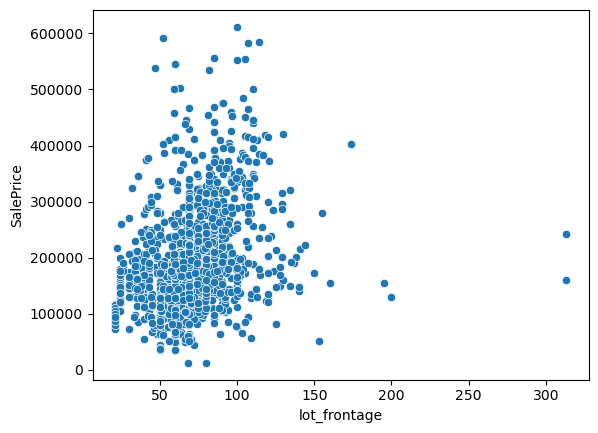

In [95]:
sns.scatterplot(x=ames['lot_frontage'], y=ames['SalePrice']);

In [96]:
ames.groupby('land_contour')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
land_contour,,
Bnk,80,142868.775000
Lvl,1843,178998.564840
Low,43,199313.116279
HLS,85,262353.376471


In [97]:
ames.groupby('lot_config')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
lot_config,,
FR2,60,174703.600000
Inside,1503,177537.014637
Corner,348,180629.591954
FR3,9,198600.000000
CulDSac,131,230744.358779


In [98]:
ames.groupby('land_slope')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
land_slope,,
Gtl,1953,180358.476703
Sev,10,194598.000000
Mod,88,204639.465909


In [99]:
ames['alley'].replace(np.nan, 'no_alley_access', inplace=True)

In [100]:
ames.groupby('alley')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
alley,,
gravel,85,120835.635294
paved,55,174534.709091
no_alley_access,1911,184366.258503


In [101]:
ames.groupby('lot_shape')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
lot_shape,,
Reg,1295,162925.812355
IR3,9,193182.222222
IR1,692,211848.670520
IR2,55,233954.745455


In [102]:
ames.groupby('neighborhood')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
neighborhood,,
MeadowV,24,100231.250000
IDOTRR,69,101103.188406
BrDale,19,103371.052632
OldTown,163,125276.300613
BrkSide,76,127022.697368
Edwards,143,130493.468531
SWISU,32,134758.875000
Landmrk,1,137000.000000
Sawyer,111,137181.909910


In [103]:
ames.groupby('condition_1')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
condition_1,,
Artery,70,128765.000000
RRNe,3,129616.666667
RRAe,21,139685.714286
Feedr,109,143223.605505
RRAn,36,172604.777778
Norm,1767,185007.310130
RRNn,6,198208.333333
PosA,12,254733.333333
PosN,27,254794.296296


In [104]:
ames.groupby('condition_2')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
condition_2,,
RRNn,2,96750.000000
Artery,5,119050.000000
Feedr,11,129181.818182
RRAn,1,136905.000000
Norm,2025,181382.075556
RRAe,1,190000.000000
PosA,3,390666.666667
PosN,3,395666.666667


In [105]:
ames.groupby('bldg_type')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
bldg_type,,
2fmCon,46,123179.891304
Twnhs,69,133100.000000
Duplex,75,139296.333333
1Fam,1700,185275.685882
TwnhsE,161,198312.372671


In [106]:
ames.house_style.value_counts(dropna=False)

1Story    1059
2Story     598
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: house_style, dtype: int64

In [107]:
ames.groupby('house_style')['SalePrice'].mean().sort_values()

house_style
1.5Unf    112466.666667
1.5Fin    136480.091743
SFoyer    149343.920000
SLvl      166248.989362
1Story    179809.194523
2.5Unf    191785.714286
2Story    206408.963211
2.5Fin    243666.666667
Name: SalePrice, dtype: float64

In [108]:
ames.overall_cond.value_counts(dropna=False)

5    1168
6     368
7     270
8     101
4      70
3      35
9      29
2       6
1       4
Name: overall_cond, dtype: int64

In [109]:
ames.groupby('overall_cond')['SalePrice'].mean().sort_values()

overall_cond
1     59625.000000
2     65364.833333
3     99786.000000
4    114034.571429
6    148952.665761
7    155327.270370
8    155913.366337
9    198177.586207
5    207055.988870
Name: SalePrice, dtype: float64

In [110]:
ames.groupby('roof_style')['SalePrice'].mean().sort_values()

roof_style
Gambrel    138208.333333
Mansard    152642.857143
Gable      171264.253243
Flat       191613.076923
Shed       208666.666667
Hip        224366.654912
Name: SalePrice, dtype: float64

In [111]:
ames.roof_style.value_counts(dropna=False)

Gable      1619
Hip         397
Flat         13
Gambrel      12
Mansard       7
Shed          3
Name: roof_style, dtype: int64

In [112]:
ames.roof_matl.value_counts(dropna=False)

CompShg    2025
Tar&Grv      15
WdShngl       5
WdShake       4
Membran       1
ClyTile       1
Name: roof_matl, dtype: int64

In [113]:
ames.exterior_1st.value_counts(dropna=False)

VinylSd    724
MetalSd    331
HdBoard    300
Wd Sdng    276
Plywood    152
CemntBd     90
BrkFace     64
WdShing     45
AsbShng     33
Stucco      27
BrkComm      3
Stone        2
CBlock       2
ImStucc      1
AsphShn      1
Name: exterior_1st, dtype: int64

In [114]:
ames.groupby('exterior_1st')['SalePrice'].mean().sort_values()

exterior_1st
AsphShn     82375.000000
CBlock      93250.000000
AsbShng    103183.333333
BrkComm    131000.000000
Stucco     139712.962963
Wd Sdng    142940.887681
MetalSd    154402.048338
WdShing    155616.822222
HdBoard    159582.473333
Plywood    170511.453947
BrkFace    193055.093750
VinylSd    218174.082873
CemntBd    243429.088889
Stone      258500.000000
ImStucc    262000.000000
Name: SalePrice, dtype: float64

In [115]:
ames.exterior_2nd.value_counts(dropna=False)

VinylSd    721
MetalSd    324
HdBoard    275
Wd Sdng    262
Plywood    185
CmentBd     90
Wd Shng     63
BrkFace     34
Stucco      30
AsbShng     28
Brk Cmn     17
ImStucc     11
Stone        6
AsphShn      3
CBlock       2
Name: exterior_2nd, dtype: int64

In [116]:
ames.groupby('exterior_2nd')['SalePrice'].mean().sort_values()

exterior_2nd
CBlock      92000.000000
AsbShng    107108.928571
AsphShn    132125.000000
Brk Cmn    139958.823529
Stone      145420.666667
Wd Sdng    145654.396947
Stucco     147725.333333
Wd Shng    154244.444444
MetalSd    155978.635802
HdBoard    160836.880000
Plywood    166485.713514
BrkFace    187992.647059
VinylSd    217798.685160
ImStucc    227472.727273
CmentBd    239540.200000
Name: SalePrice, dtype: float64

In [117]:
ames.exter_qual.value_counts(dropna=False)

TA    1247
Gd     697
Ex      81
Fa      26
Name: exter_qual, dtype: int64

In [118]:
ames.groupby('exter_qual')['SalePrice'].mean().sort_values()

exter_qual
Fa     89801.192308
TA    143270.978348
Gd    230802.484935
Ex    374460.308642
Name: SalePrice, dtype: float64

In [119]:
ames.exter_cond.value_counts(dropna=False)

TA    1778
Gd     215
Fa      49
Ex       7
Po       2
Name: exter_cond, dtype: int64

In [120]:
ames.groupby('exter_cond')['SalePrice'].mean().sort_values()

exter_cond
Po     44800.000000
Fa    102507.693878
Gd    167623.023256
TA    185258.202475
Ex    236263.857143
Name: SalePrice, dtype: float64

In [121]:
ames.foundation.value_counts(dropna=False)

PConc     926
CBlock    863
BrkTil    221
Slab       34
Stone       5
Wood        2
Name: foundation, dtype: int64

In [122]:
ames.groupby('foundation')['SalePrice'].mean().sort_values()

foundation
Slab      108810.676471
BrkTil    129050.190045
Stone     143235.200000
CBlock    148415.530707
Wood      173750.000000
PConc     227676.483801
Name: SalePrice, dtype: float64

In [123]:
ames.bsmt_qual.value_counts(dropna=False)

average        887
good           864
excellent      184
fair            60
NaN             55
poor             1
no_basement      0
Name: bsmt_qual, dtype: int64

In [124]:
ames.bsmt_exposure.value_counts(dropna=False)

no_exposure      1339
avg_exposure      288
good_exposure     203
min_exposure      163
NaN                58
no_basement         0
Name: bsmt_exposure, dtype: int64

In [125]:
ames.groupby('bsmt_exposure')['SalePrice'].mean().sort_values()

bsmt_exposure
no_exposure      164533.532487
min_exposure     189377.570552
avg_exposure     206262.451389
good_exposure    271610.566502
no_basement                NaN
Name: SalePrice, dtype: float64

In [126]:
ames['bsmtfin_type_2'].value_counts(dropna=False)

unf            1749
rec              80
lwq              60
NaN              56
blq              48
alq              35
glq              23
no_basement       0
Name: bsmtfin_type_2, dtype: int64

In [127]:
ames.groupby('heating')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
heating,,
Grav,5,65180.00000
Wall,6,77150.00000
OthW,2,125750.00000
GasW,20,151275.00000
GasA,2018,182422.47671


In [128]:
ames.groupby('heating_qc')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
heating_qc,,
Po,3,69033.333333
Fa,67,117123.641791
TA,597,138986.705193
Gd,319,160174.009404
Ex,1065,216027.607512


In [129]:
ames.groupby('central_air')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
central_air,,
N,141,100575.078014
Y,1910,187441.503665


In [130]:
ames.groupby('electrical')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
electrical,,
Mix,1,67000.000000
FuseP,7,83485.714286
FuseF,35,103678.914286
FuseA,140,122565.157143
SBrkr,1868,187770.382227


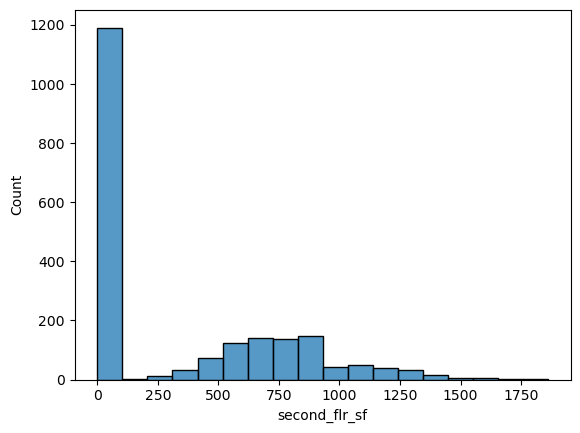

In [131]:
sns.histplot(ames['second_flr_sf']);

<Axes: xlabel='kitchen_abvgr', ylabel='Count'>

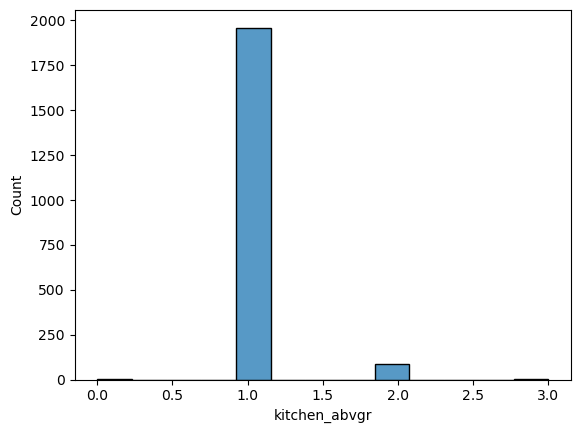

In [132]:
sns.histplot(ames['kitchen_abvgr'])

In [133]:
ames.groupby('kitchen_qual')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
kitchen_qual,,
Fa,47,101334.957447
TA,1047,139501.607450
Gd,806,211629.451613
Ex,151,336424.463576


In [134]:
ames.groupby('functional')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
functional,,
Sal,2,31550.000000
Maj2,7,87157.714286
Sev,2,95750.000000
Mod,29,148108.724138
Min2,42,150424.571429
Min1,42,154429.761905
Maj1,12,163106.166667
Typ,1915,183954.749347


<Axes: xlabel='fireplaces', ylabel='Count'>

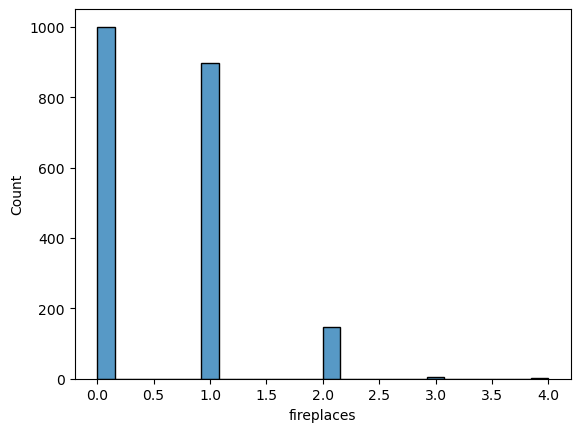

In [135]:
sns.histplot(ames['fireplaces'])

In [136]:
ames.groupby('fireplaces')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
fireplaces,,
0,1000,142001.103000
1,898,215478.776169
3,6,234808.333333
2,146,239893.589041
4,1,260000.000000


In [137]:
ames['garage_cars'].value_counts(dropna=False)

2.0    1136
1.0     524
3.0     263
0.0     114
4.0      13
5.0       1
Name: garage_cars, dtype: int64

In [138]:
ames.groupby('paved_drive')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
paved_drive,,
N,151,104562.827815
P,39,129824.461538
Y,1861,188792.163890


In [139]:
ames['two_car_garage'] = np.where(ames['garage_cars'] == 2, 'Yes', 'No')
ames['one_car_garage'] = np.where(ames['garage_cars'] == 1, 'Yes', 'No')
ames['three_car_garage'] = np.where(ames['garage_cars'] == 3, 'Yes', 'No')

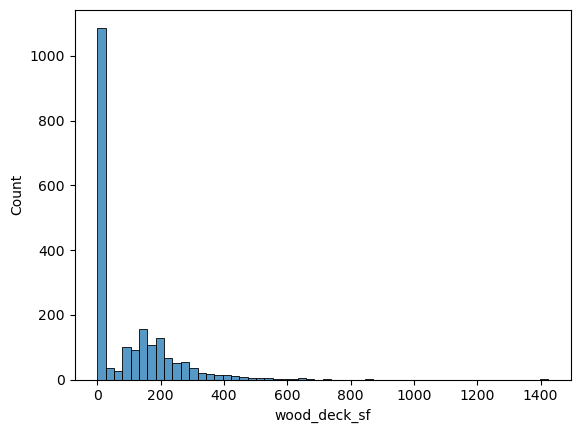

In [140]:
sns.histplot(ames['wood_deck_sf']);

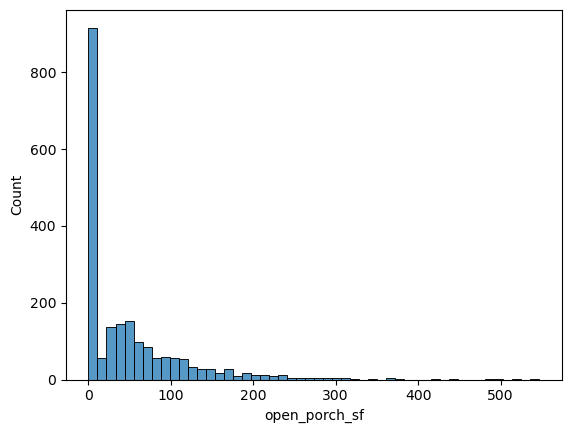

In [141]:
sns.histplot(ames['open_porch_sf']);

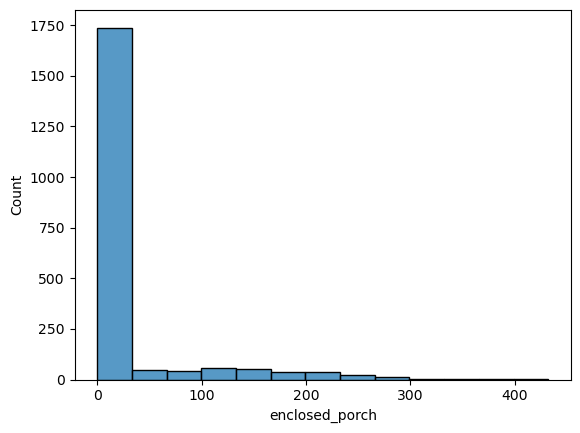

In [142]:
sns.histplot(ames['enclosed_porch']);

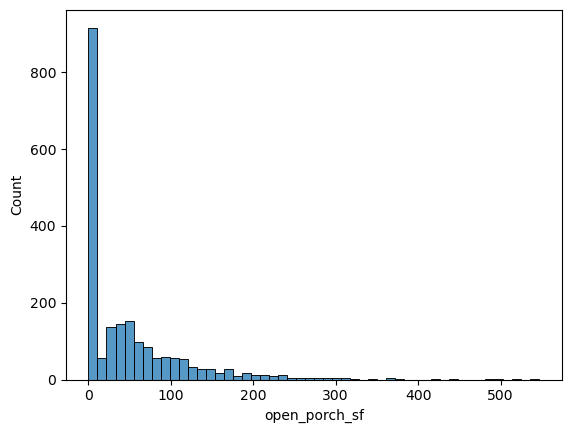

In [143]:
sns.histplot(ames['open_porch_sf']);

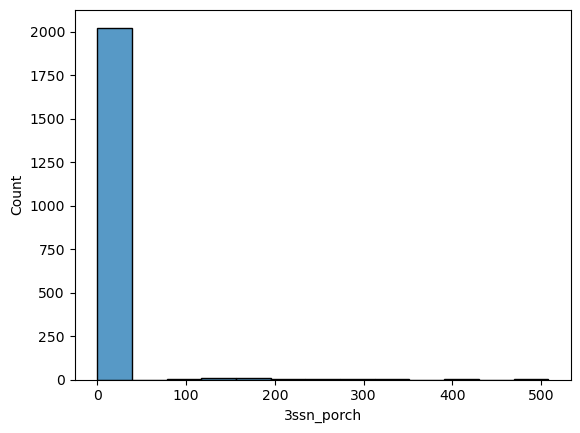

In [144]:
sns.histplot(ames['3ssn_porch']);

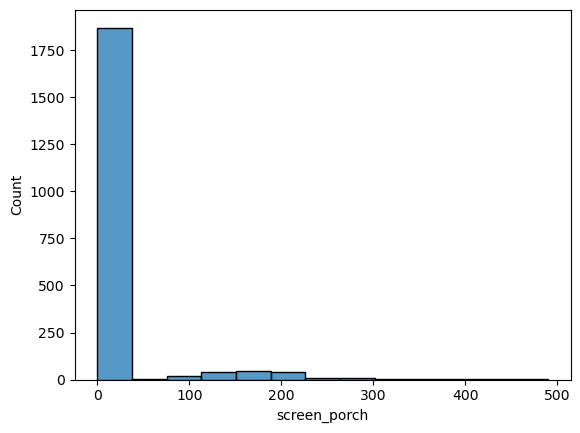

In [145]:
sns.histplot(ames['screen_porch']);

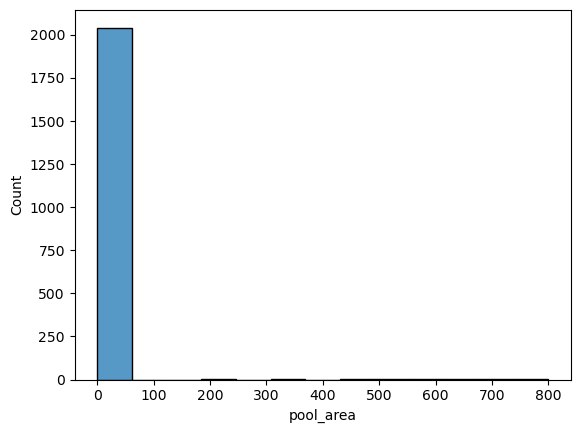

In [146]:
sns.histplot(ames['pool_area']);

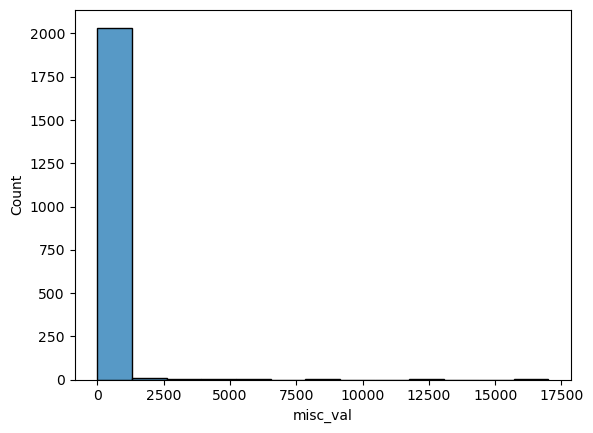

In [147]:
sns.histplot(ames['misc_val']);

In [148]:
ames.groupby('sale_type')['SalePrice'].agg(['count', 'mean']).sort_values('mean')

,count,mean
sale_type,,
ConLw,5,124600.000000
Oth,4,127497.750000
ConLD,17,129091.352941
COD,63,133574.523810
WD,1781,174912.251544
CWD,10,186635.000000
ConLI,7,207992.857143
Con,4,241807.500000
New,160,279021.056250
